In [1]:
import os

import torch
import torch.nn.utils.prune as prune
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

from models import *
from pruning_methods import *

import pandas as pd
import numpy as np

from tqdm import tqdm
import seaborn as sns

### Prepare test data

In [2]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified


### Load pre-trained model and check params

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = ResNet20()
net = net.to(device)

print('==> Loading from checkpoint..')
assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
checkpoint = torch.load('./checkpoint/ckpt.pth')
net.load_state_dict(checkpoint['net'])
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']
net = net.to(device)
print("Loaded checkpoint w accuracy", best_acc, "%")

==> Loading from checkpoint..
Loaded checkpoint w accuracy 92.92 %


In [4]:
net.children

<bound method Module.children of ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16,

In [5]:
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,304
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
        BasicBlock-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
           Conv2d-10           [-1, 16, 32, 32]           2,304
      BatchNorm2d-11           [-1, 16, 32, 32]              32
       BasicBlock-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]           2,304
      BatchNorm2d-14           [-1, 16,

### Helper methods to run experiments

In [6]:
#we will use K-means clustering method for now
custom_pruner = KMeansPruner()
    
def prune_net(net, amount, i):
    num_pruned_params = 0
    convl = 0 #index needed to use amount array
    
    for name, module in net.named_modules():
        if isinstance(module, torch.nn.Conv2d) and ('layer' in name):
            
#             #make net reset weights to not cluster centroids 
#             #and not to sum masks
#             if i > 0:
#                 module.weight.data = module.weight_orig.data
#                 module.weight_mask.data = torch.ones_like(module.weight_mask).data

            #get mask and centroided weights
            mask, new_weights = custom_pruner.get_masks_and_centroids(
                module.weight, 
                module.weight.shape[0] - amount[convl])

            #prune using torch built-in method
            prune.custom_from_mask(module, "weight", mask)
        
            module.weight.data = new_weights.data
            
            num_pruned_params += (len(module.weight.flatten()) - 
                                  len(module.weight_mask.flatten().nonzero()))            
            convl += 1

    return num_pruned_params


def reload_net(device='cpu', checkpoint_path='./checkpoint/ckpt.pth'):
    net = ResNet20()
    net = net.to(device)
    
    checkpoint = torch.load(checkpoint_path)
    
    net.load_state_dict(checkpoint['net'])
    net = net.to(device)
    return net

In [7]:
criterion = torch.nn.CrossEntropyLoss()

def test(net, epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        with tqdm(testloader, unit="batch") as tepoch:
            for batch_idx, (inputs, targets) in enumerate(tepoch):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                tepoch.set_postfix(loss=test_loss/(batch_idx+1), 
                                   accuracy=correct/total)
    return correct/total

In [8]:
def run_experiment(net, amount_to_prune, i):
    net = reload_net()
    num_pruned_params = prune_net(net, amount_to_prune, i)
    accuracy = test(net, start_epoch)
    return num_pruned_params, accuracy


def show_results(results, total_params=269722):
    results["perc_pruned_params"] = results["number_pruned_params"] / total_params
    sns.lineplot(data=results, x="perc_pruned_params", y=("accuracy"))
    return results

### Experiment 1

В первом эксперименте посмотрим, как влияет прунинг на сеть, если количество кластеров выбирается как доля от количества фильтров в каждом слое. Предварительные тесты показали, что лучше брать значения доли <=0.1-0.2, так как в противном случае точность падает слишком сильно

In [19]:
results = pd.DataFrame(columns=["number_pruned_params", "accuracy"])

#массив из 18 значений, т.к. у нас 9 блоков по 2 сверточных слоя (3 по 16 фильтров, 3 - 32, 3 - 64)
amount_to_prun = np.array([16] * 6 + [32] * 6 + [64] * 6)

for i in range(10):
    arr = (amount_to_prun * 0.025 * i).astype(int)
    print("# of filters to prune for each layer:", arr)
    
    results.loc[len(results)] = run_experiment(net, arr, i)

# of filters to prune for each layer: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:22<00:00,  4.43batch/s, accuracy=0.929, loss=0.265]


# of filters to prune for each layer: [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:23<00:00,  4.35batch/s, accuracy=0.793, loss=0.882]


# of filters to prune for each layer: [0 0 0 0 0 0 1 1 1 1 1 1 3 3 3 3 3 3]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:23<00:00,  4.32batch/s, accuracy=0.713, loss=0.91]


# of filters to prune for each layer: [1 1 1 1 1 1 2 2 2 2 2 2 4 4 4 4 4 4]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:23<00:00,  4.32batch/s, accuracy=0.499, loss=1.72]


# of filters to prune for each layer: [1 1 1 1 1 1 3 3 3 3 3 3 6 6 6 6 6 6]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:22<00:00,  4.36batch/s, accuracy=0.586, loss=1.82]


# of filters to prune for each layer: [2 2 2 2 2 2 4 4 4 4 4 4 8 8 8 8 8 8]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:22<00:00,  4.40batch/s, accuracy=0.175, loss=5.11]


# of filters to prune for each layer: [2 2 2 2 2 2 4 4 4 4 4 4 9 9 9 9 9 9]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:23<00:00,  4.31batch/s, accuracy=0.305, loss=2.26]


# of filters to prune for each layer: [ 2  2  2  2  2  2  5  5  5  5  5  5 11 11 11 11 11 11]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|████████████| 100/100 [00:22<00:00,  4.39batch/s, accuracy=0.243, loss=2.3]


# of filters to prune for each layer: [ 3  3  3  3  3  3  6  6  6  6  6  6 12 12 12 12 12 12]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:23<00:00,  4.32batch/s, accuracy=0.152, loss=4.15]


# of filters to prune for each layer: [ 3  3  3  3  3  3  7  7  7  7  7  7 14 14 14 14 14 14]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:23<00:00,  4.33batch/s, accuracy=0.112, loss=7.83]


,number_pruned_params,accuracy,perc_pruned_params
0,0.0,0.9292,0.000000
1,3168.0,0.7928,0.011745
2,11088.0,0.7125,0.041109
3,16704.0,0.4986,0.061930
4,24624.0,0.5857,0.091294
5,33408.0,0.1751,0.123861
6,36576.0,0.3048,0.135606
7,44496.0,0.2433,0.164970
8,50112.0,0.1520,0.185791
9,58032.0,0.1118,0.215155


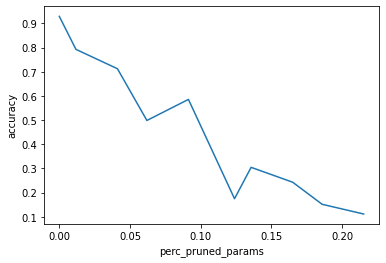

In [20]:
show_results(results)

Видно, что точность довольно сильно проседает даже при небольших обнулениях параметров 

### Experiment 2

Теперь посмотрим, как влияет прунинг на сеть, если количество кластеров для всех слоев одинаково

In [13]:
results = pd.DataFrame(columns=["number_pruned_params", "accuracy"])

for i in range(10):
    arr = [i*1] * 18
    print("# of filters to prune for each layer:", arr)
    
    results.loc[len(results)] = run_experiment(net, arr, i)

# of filters to prune for each layer: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:26<00:00,  3.83batch/s, accuracy=0.929, loss=0.265]


# of filters to prune for each layer: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:23<00:00,  4.31batch/s, accuracy=0.793, loss=0.893]


# of filters to prune for each layer: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:22<00:00,  4.35batch/s, accuracy=0.643, loss=1.79]


# of filters to prune for each layer: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|████████████| 100/100 [00:24<00:00,  4.07batch/s, accuracy=0.449, loss=2.2]


# of filters to prune for each layer: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:22<00:00,  4.39batch/s, accuracy=0.143, loss=7.39]


# of filters to prune for each layer: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:22<00:00,  4.40batch/s, accuracy=0.264, loss=3.85]


# of filters to prune for each layer: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:27<00:00,  3.61batch/s, accuracy=0.184, loss=7.82]


# of filters to prune for each layer: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|████████████| 100/100 [00:22<00:00,  4.40batch/s, accuracy=0.117, loss=7.9]


# of filters to prune for each layer: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:22<00:00,  4.38batch/s, accuracy=0.134, loss=6.22]


# of filters to prune for each layer: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:22<00:00,  4.43batch/s, accuracy=0.105, loss=2.85]


,number_pruned_params,accuracy,perc_pruned_params
0,0.0,0.9292,0.000000
1,5616.0,0.7934,0.020821
2,11232.0,0.6426,0.041643
3,16848.0,0.4487,0.062464
4,22464.0,0.1429,0.083286
5,28080.0,0.2641,0.104107
6,33696.0,0.1838,0.124929
7,39312.0,0.1175,0.145750
8,44928.0,0.1335,0.166572
9,50544.0,0.1050,0.187393


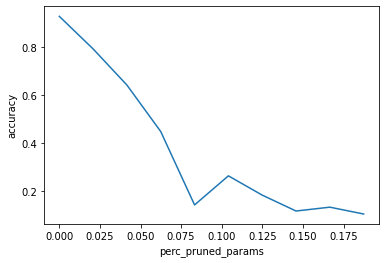

In [14]:
show_results(results)

Видно, что когда бОльшее влияние прунинг оказывает на первые слои, которые сами по себе меньше, точность  проседает еще сильнее

### Experiment 3

Теперь посмотрим, что будет, если со средних слоев удалять больше всего весов

In [28]:
results = pd.DataFrame(columns=["number_pruned_params", "accuracy"])
amount_to_prun = np.array([16] * 6 + [32] * 6 + [64] * 6)

for i in range(10):
    arr = [int(
        min(j, len(amount_to_prun) - j - 1) // 2 * 0.5 * (i)
              ) for j, el in enumerate(amount_to_prun)]
    print("# of filters to prune for each layer:", arr)
    
    results.loc[len(results)] = run_experiment(net, arr, i)

# of filters to prune for each layer: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:24<00:00,  4.07batch/s, accuracy=0.929, loss=0.265]


# of filters to prune for each layer: [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:22<00:00,  4.36batch/s, accuracy=0.92, loss=0.296]


# of filters to prune for each layer: [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 3, 3, 2, 2, 1, 1, 0, 0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:22<00:00,  4.37batch/s, accuracy=0.825, loss=0.768]


# of filters to prune for each layer: [0, 0, 1, 1, 3, 3, 4, 4, 6, 6, 4, 4, 3, 3, 1, 1, 0, 0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:22<00:00,  4.37batch/s, accuracy=0.473, loss=2.61]


# of filters to prune for each layer: [0, 0, 2, 2, 4, 4, 6, 6, 8, 8, 6, 6, 4, 4, 2, 2, 0, 0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:22<00:00,  4.41batch/s, accuracy=0.295, loss=4.52]


# of filters to prune for each layer: [0, 0, 2, 2, 5, 5, 7, 7, 10, 10, 7, 7, 5, 5, 2, 2, 0, 0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:22<00:00,  4.37batch/s, accuracy=0.183, loss=7.78]


# of filters to prune for each layer: [0, 0, 3, 3, 6, 6, 9, 9, 12, 12, 9, 9, 6, 6, 3, 3, 0, 0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:22<00:00,  4.42batch/s, accuracy=0.108, loss=8.68]


# of filters to prune for each layer: [0, 0, 3, 3, 7, 7, 10, 10, 14, 14, 10, 10, 7, 7, 3, 3, 0, 0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|████████████| 100/100 [00:22<00:00,  4.36batch/s, accuracy=0.133, loss=5.9]


# of filters to prune for each layer: [0, 0, 4, 4, 8, 8, 12, 12, 16, 16, 12, 12, 8, 8, 4, 4, 0, 0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:22<00:00,  4.42batch/s, accuracy=0.102, loss=7.86]


# of filters to prune for each layer: [0, 0, 4, 4, 9, 9, 13, 13, 18, 18, 13, 13, 9, 9, 4, 4, 0, 0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:22<00:00,  4.45batch/s, accuracy=0.107, loss=9.26]


,number_pruned_params,accuracy,perc_pruned_params
0,0.0,0.9292,0.000000
1,3312.0,0.9204,0.012279
2,9072.0,0.8253,0.033635
3,12384.0,0.4729,0.045914
4,18144.0,0.2946,0.067269
5,21456.0,0.1832,0.079549
6,27216.0,0.1077,0.100904
7,30528.0,0.1326,0.113183
8,36288.0,0.1019,0.134539
9,39600.0,0.1071,0.146818


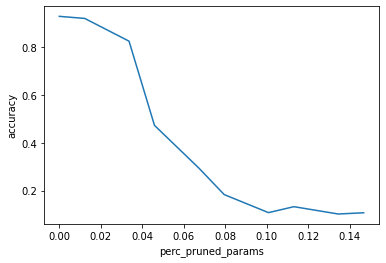

In [29]:
show_results(results)

In [47]:
results = pd.DataFrame(columns=["number_pruned_params", "accuracy"])
amount_to_prun = np.array([0] * 6 + [1] * 6 + [0] * 6)

for i in range(10):
    arr = amount_to_prun * i * 3
    print("# of filters to prune for each layer:", arr)
    
    results.loc[len(results)] = run_experiment(net, arr, i)

# of filters to prune for each layer: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:22<00:00,  4.37batch/s, accuracy=0.929, loss=0.265]


# of filters to prune for each layer: [0 0 0 0 0 0 3 3 3 3 3 3 0 0 0 0 0 0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|████████████| 100/100 [00:22<00:00,  4.43batch/s, accuracy=0.9, loss=0.372]


# of filters to prune for each layer: [0 0 0 0 0 0 6 6 6 6 6 6 0 0 0 0 0 0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:23<00:00,  4.32batch/s, accuracy=0.823, loss=0.649]


# of filters to prune for each layer: [0 0 0 0 0 0 9 9 9 9 9 9 0 0 0 0 0 0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:23<00:00,  4.27batch/s, accuracy=0.185, loss=4.96]


# of filters to prune for each layer: [ 0  0  0  0  0  0 12 12 12 12 12 12  0  0  0  0  0  0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:27<00:00,  3.58batch/s, accuracy=0.155, loss=4.89]


# of filters to prune for each layer: [ 0  0  0  0  0  0 15 15 15 15 15 15  0  0  0  0  0  0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:27<00:00,  3.58batch/s, accuracy=0.127, loss=7.69]


# of filters to prune for each layer: [ 0  0  0  0  0  0 18 18 18 18 18 18  0  0  0  0  0  0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:23<00:00,  4.20batch/s, accuracy=0.095, loss=14.4]


# of filters to prune for each layer: [ 0  0  0  0  0  0 21 21 21 21 21 21  0  0  0  0  0  0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:26<00:00,  3.72batch/s, accuracy=0.119, loss=7.86]


# of filters to prune for each layer: [ 0  0  0  0  0  0 24 24 24 24 24 24  0  0  0  0  0  0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:25<00:00,  4.00batch/s, accuracy=0.152, loss=6.56]


# of filters to prune for each layer: [ 0  0  0  0  0  0 27 27 27 27 27 27  0  0  0  0  0  0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:27<00:00,  3.69batch/s, accuracy=0.122, loss=8.15]


,number_pruned_params,accuracy,perc_pruned_params
0,0.0,0.9292,0.000000
1,4752.0,0.8997,0.017618
2,9504.0,0.8234,0.035236
3,14256.0,0.1851,0.052854
4,19008.0,0.1548,0.070473
5,23760.0,0.1268,0.088091
6,28512.0,0.0950,0.105709
7,33264.0,0.1194,0.123327
8,38016.0,0.1518,0.140945
9,42768.0,0.1220,0.158563


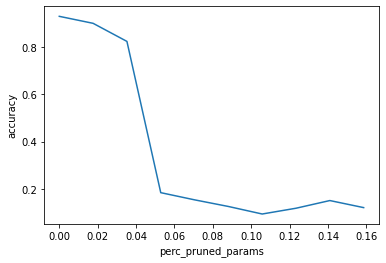

In [48]:
show_results(results)

### Experiment 4

Попробуем удалять веса из первых и последних слоев каждого блока

In [67]:
results = pd.DataFrame(columns=["number_pruned_params", "accuracy"])
amount_to_prun = np.array([0, 1] * 9)

for i in range(10):
    arr = amount_to_prun * i
    arr[7:15] = arr[7:15] * 3
    print("# of filters to prune for each layer:", arr)
    
    results.loc[len(results)] = run_experiment(net, arr, i)

# of filters to prune for each layer: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:34<00:00,  2.87batch/s, accuracy=0.929, loss=0.265]


# of filters to prune for each layer: [0 1 0 1 0 1 0 3 0 3 0 3 0 3 0 1 0 1]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:24<00:00,  4.14batch/s, accuracy=0.907, loss=0.362]


# of filters to prune for each layer: [0 2 0 2 0 2 0 6 0 6 0 6 0 6 0 2 0 2]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:28<00:00,  3.47batch/s, accuracy=0.869, loss=0.543]


# of filters to prune for each layer: [0 3 0 3 0 3 0 9 0 9 0 9 0 9 0 3 0 3]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:24<00:00,  4.09batch/s, accuracy=0.828, loss=0.753]


# of filters to prune for each layer: [ 0  4  0  4  0  4  0 12  0 12  0 12  0 12  0  4  0  4]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:25<00:00,  4.00batch/s, accuracy=0.633, loss=1.96]


# of filters to prune for each layer: [ 0  5  0  5  0  5  0 15  0 15  0 15  0 15  0  5  0  5]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:26<00:00,  3.77batch/s, accuracy=0.409, loss=3.99]


# of filters to prune for each layer: [ 0  6  0  6  0  6  0 18  0 18  0 18  0 18  0  6  0  6]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:24<00:00,  4.04batch/s, accuracy=0.318, loss=5.43]


# of filters to prune for each layer: [ 0  7  0  7  0  7  0 21  0 21  0 21  0 21  0  7  0  7]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|█████████████| 100/100 [00:25<00:00,  3.91batch/s, accuracy=0.101, loss=20]


# of filters to prune for each layer: [ 0  8  0  8  0  8  0 24  0 24  0 24  0 24  0  8  0  8]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|████████████| 100/100 [00:33<00:00,  3.02batch/s, accuracy=0.11, loss=21.2]


# of filters to prune for each layer: [ 0  9  0  9  0  9  0 27  0 27  0 27  0 27  0  9  0  9]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:23<00:00,  4.30batch/s, accuracy=0.0995, loss=18.1]


,number_pruned_params,accuracy,perc_pruned_params
0,0.0,0.9292,0.000000
1,5904.0,0.9074,0.021889
2,11808.0,0.8694,0.043778
3,17712.0,0.8276,0.065668
4,23616.0,0.6328,0.087557
5,29520.0,0.4093,0.109446
6,35424.0,0.3179,0.131335
7,41328.0,0.1008,0.153224
8,47232.0,0.1097,0.175114
9,53136.0,0.0995,0.197003


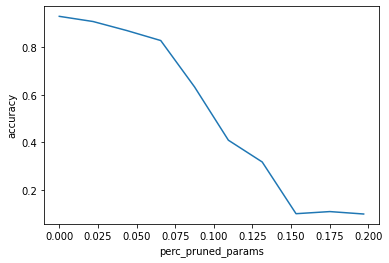

In [68]:
show_results(results)

In [72]:
results = pd.DataFrame(columns=["number_pruned_params", "accuracy"])
amount_to_prun = np.array([1, 0] * 9)

for i in range(10):
    arr = amount_to_prun * i
    arr[6:15] = arr[6:15] * 3
    print("# of filters to prune for each layer:", arr)
    
    results.loc[len(results)] = run_experiment(net, arr, i)

# of filters to prune for each layer: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:29<00:00,  3.45batch/s, accuracy=0.929, loss=0.265]


# of filters to prune for each layer: [1 0 1 0 1 0 3 0 3 0 3 0 3 0 3 0 1 0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:28<00:00,  3.49batch/s, accuracy=0.425, loss=2.12]


# of filters to prune for each layer: [2 0 2 0 2 0 6 0 6 0 6 0 6 0 6 0 2 0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:23<00:00,  4.35batch/s, accuracy=0.466, loss=2.88]


# of filters to prune for each layer: [3 0 3 0 3 0 9 0 9 0 9 0 9 0 9 0 3 0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:26<00:00,  3.71batch/s, accuracy=0.102, loss=2.64]


# of filters to prune for each layer: [ 4  0  4  0  4  0 12  0 12  0 12  0 12  0 12  0  4  0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|█████████████| 100/100 [00:22<00:00,  4.35batch/s, accuracy=0.1, loss=5.83]


# of filters to prune for each layer: [ 5  0  5  0  5  0 15  0 15  0 15  0 15  0 15  0  5  0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|█████████████| 100/100 [00:25<00:00,  3.90batch/s, accuracy=0.1, loss=2.85]


# of filters to prune for each layer: [ 6  0  6  0  6  0 18  0 18  0 18  0 18  0 18  0  6  0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|█████████████| 100/100 [00:22<00:00,  4.41batch/s, accuracy=0.1, loss=3.14]


# of filters to prune for each layer: [ 7  0  7  0  7  0 21  0 21  0 21  0 21  0 21  0  7  0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|█████████████| 100/100 [00:22<00:00,  4.43batch/s, accuracy=0.1, loss=3.19]


# of filters to prune for each layer: [ 8  0  8  0  8  0 24  0 24  0 24  0 24  0 24  0  8  0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|█████████████| 100/100 [00:24<00:00,  4.15batch/s, accuracy=0.1, loss=3.13]


# of filters to prune for each layer: [ 9  0  9  0  9  0 27  0 27  0 27  0 27  0 27  0  9  0]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|████████████████| 100/100 [00:27<00:00,  3.66batch/s, accuracy=0.1, loss=3]


,number_pruned_params,accuracy,perc_pruned_params
0,0.0,0.9292,0.000000
1,5760.0,0.4247,0.021355
2,11520.0,0.4664,0.042711
3,17280.0,0.1015,0.064066
4,23040.0,0.1002,0.085421
5,28800.0,0.1002,0.106777
6,34560.0,0.1000,0.128132
7,40320.0,0.1000,0.149487
8,46080.0,0.1000,0.170843
9,51840.0,0.1000,0.192198


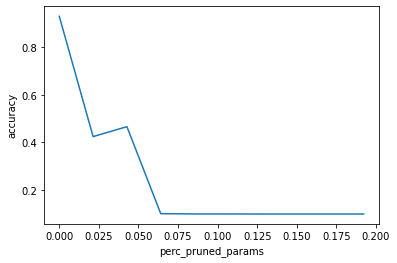

In [73]:
show_results(results)

**Удаление весов только из последнего conv2d-слоя в каждом resnet-блоке** приводит к самому медленному снижению точности среди всех проведенных экспериментов

### Compare with other methods

Для сравнения можно посмотреть, какие результаты дает прунинг с использованием других методов, в частности уже реализованных в pytorch

In [74]:
def prune_net(net, amount, i):
    num_pruned_params = 0
    convl = 0 #index needed to use amount array
    
    for name, module in net.named_modules():
        if isinstance(module, torch.nn.Conv2d) and ('layer' in name):

            #prune using torch built-in method
            prune.l1_unstructured(module, "weight", amount=amount[convl])
        
            num_pruned_params += (len(module.weight.flatten()) - 
                                  len(module.weight_mask.flatten().nonzero()))            
            convl += 1

    return num_pruned_params

In [84]:
results = pd.DataFrame(columns=["number_pruned_params", "accuracy"])
amount_to_prun = np.array([0, 0.03] * 9)

for i in range(10):
    arr = amount_to_prun * i
    arr[7:15] = arr[7:15] * 3
    print("# of filters to prune for each layer:", arr)
    
    results.loc[len(results)] = run_experiment(net, arr, i)

# of filters to prune for each layer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:26<00:00,  3.81batch/s, accuracy=0.929, loss=0.265]


# of filters to prune for each layer: [0.   0.03 0.   0.03 0.   0.03 0.   0.09 0.   0.09 0.   0.09 0.   0.09
 0.   0.03 0.   0.03]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:24<00:00,  4.10batch/s, accuracy=0.929, loss=0.265]


# of filters to prune for each layer: [0.   0.06 0.   0.06 0.   0.06 0.   0.18 0.   0.18 0.   0.18 0.   0.18
 0.   0.06 0.   0.06]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:25<00:00,  3.94batch/s, accuracy=0.928, loss=0.265]


# of filters to prune for each layer: [0.   0.09 0.   0.09 0.   0.09 0.   0.27 0.   0.27 0.   0.27 0.   0.27
 0.   0.09 0.   0.09]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:25<00:00,  3.88batch/s, accuracy=0.927, loss=0.269]


# of filters to prune for each layer: [0.   0.12 0.   0.12 0.   0.12 0.   0.36 0.   0.36 0.   0.36 0.   0.36
 0.   0.12 0.   0.12]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:23<00:00,  4.30batch/s, accuracy=0.925, loss=0.278]


# of filters to prune for each layer: [0.   0.15 0.   0.15 0.   0.15 0.   0.45 0.   0.45 0.   0.45 0.   0.45
 0.   0.15 0.   0.15]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:23<00:00,  4.20batch/s, accuracy=0.923, loss=0.298]


# of filters to prune for each layer: [0.   0.18 0.   0.18 0.   0.18 0.   0.54 0.   0.54 0.   0.54 0.   0.54
 0.   0.18 0.   0.18]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:26<00:00,  3.82batch/s, accuracy=0.918, loss=0.323]


# of filters to prune for each layer: [0.   0.21 0.   0.21 0.   0.21 0.   0.63 0.   0.63 0.   0.63 0.   0.63
 0.   0.21 0.   0.21]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:23<00:00,  4.20batch/s, accuracy=0.905, loss=0.375]


# of filters to prune for each layer: [0.   0.24 0.   0.24 0.   0.24 0.   0.72 0.   0.72 0.   0.72 0.   0.72
 0.   0.24 0.   0.24]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:23<00:00,  4.25batch/s, accuracy=0.884, loss=0.486]


# of filters to prune for each layer: [0.   0.27 0.   0.27 0.   0.27 0.   0.81 0.   0.81 0.   0.81 0.   0.81
 0.   0.27 0.   0.27]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:25<00:00,  3.95batch/s, accuracy=0.799, loss=0.902]


,number_pruned_params,accuracy,perc_pruned_params
0,0.0,0.9292,0.000000
1,8224.0,0.9292,0.030491
2,16451.0,0.9285,0.060992
3,24674.0,0.9275,0.091479
4,32901.0,0.9252,0.121981
5,41128.0,0.9234,0.152483
6,49355.0,0.9179,0.182985
7,57576.0,0.9053,0.213464
8,65803.0,0.8836,0.243966
9,74027.0,0.7986,0.274457


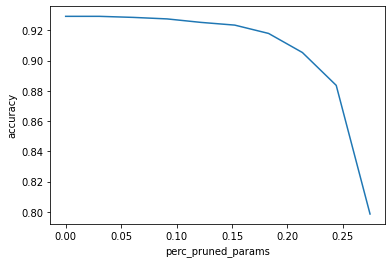

In [85]:
show_results(results)

In [107]:
def prune_net(net, amount, i):
    num_pruned_params = 0
    convl = 0 #index needed to use amount array
    
    for name, module in net.named_modules():
        if isinstance(module, torch.nn.Conv2d) and ('layer' in name):

            #prune using torch built-in method
            prune.ln_structured(module, "weight", amount=amount[convl], 
                                dim=0, n=2)
        
            num_pruned_params += (len(module.weight.flatten()) - 
                                  len(module.weight_mask.flatten().nonzero()))            
            convl += 1

    return num_pruned_params

In [108]:
results = pd.DataFrame(columns=["number_pruned_params", "accuracy"])
amount_to_prun = np.array([0, 0.03] * 9)

for i in range(10):
    arr = amount_to_prun * i
    arr[7:15] = arr[7:15] * 3
    print("# of filters to prune for each layer:", arr)
    
    results.loc[len(results)] = run_experiment(net, arr, i)

# of filters to prune for each layer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:25<00:00,  3.93batch/s, accuracy=0.929, loss=0.265]


# of filters to prune for each layer: [0.   0.03 0.   0.03 0.   0.03 0.   0.09 0.   0.09 0.   0.09 0.   0.09
 0.   0.03 0.   0.03]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:29<00:00,  3.36batch/s, accuracy=0.917, loss=0.321]


# of filters to prune for each layer: [0.   0.06 0.   0.06 0.   0.06 0.   0.18 0.   0.18 0.   0.18 0.   0.18
 0.   0.06 0.   0.06]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:31<00:00,  3.14batch/s, accuracy=0.888, loss=0.459]


# of filters to prune for each layer: [0.   0.09 0.   0.09 0.   0.09 0.   0.27 0.   0.27 0.   0.27 0.   0.27
 0.   0.09 0.   0.09]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|██████████| 100/100 [00:31<00:00,  3.21batch/s, accuracy=0.829, loss=0.798]


# of filters to prune for each layer: [0.   0.12 0.   0.12 0.   0.12 0.   0.36 0.   0.36 0.   0.36 0.   0.36
 0.   0.12 0.   0.12]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:25<00:00,  3.90batch/s, accuracy=0.637, loss=2.31]


# of filters to prune for each layer: [0.   0.15 0.   0.15 0.   0.15 0.   0.45 0.   0.45 0.   0.45 0.   0.45
 0.   0.15 0.   0.15]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|████████████| 100/100 [00:23<00:00,  4.33batch/s, accuracy=0.535, loss=3.5]


# of filters to prune for each layer: [0.   0.18 0.   0.18 0.   0.18 0.   0.54 0.   0.54 0.   0.54 0.   0.54
 0.   0.18 0.   0.18]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:25<00:00,  3.94batch/s, accuracy=0.438, loss=5.14]


# of filters to prune for each layer: [0.   0.21 0.   0.21 0.   0.21 0.   0.63 0.   0.63 0.   0.63 0.   0.63
 0.   0.21 0.   0.21]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:23<00:00,  4.30batch/s, accuracy=0.394, loss=4.99]


# of filters to prune for each layer: [0.   0.24 0.   0.24 0.   0.24 0.   0.72 0.   0.72 0.   0.72 0.   0.72
 0.   0.24 0.   0.24]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:24<00:00,  4.13batch/s, accuracy=0.195, loss=7.62]


# of filters to prune for each layer: [0.   0.27 0.   0.27 0.   0.27 0.   0.81 0.   0.81 0.   0.81 0.   0.81
 0.   0.27 0.   0.27]


  0%|                                                | 0/100 [00:00<?, ?batch/s][W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
100%|███████████| 100/100 [00:24<00:00,  4.13batch/s, accuracy=0.112, loss=10.4]


,number_pruned_params,accuracy,perc_pruned_params
0,0.0,0.9292,0.000000
1,8352.0,0.9170,0.030965
2,17136.0,0.8883,0.063532
3,24912.0,0.8285,0.092362
4,33696.0,0.6372,0.124929
5,41184.0,0.5355,0.152691
6,49968.0,0.4379,0.185257
7,56592.0,0.3936,0.209816
8,65376.0,0.1950,0.242383
9,73728.0,0.1115,0.273348


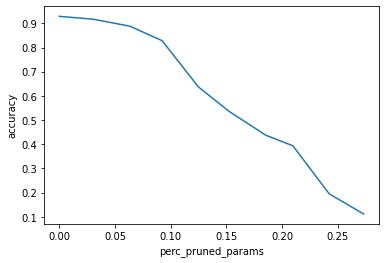

In [109]:
show_results(results)

## Выводы

Пока в помощью структурированного кластеризационного прунинга не удалось добиться существенного снижения количества параметров при сохранении точности сети. 
Наилучшим из рассмотренных оказался подход с **удалением весов только из последнего conv2d-слоя в каждом resnet-блоке**, причем в средних блоках сети количество кластеров было меньше, чем в начальных и конечных 


Методы прунинга, реализованные в торче, дают более хороший результат (l-n-norm-structured и l1-norm-unstructured)

Возможно, причина отчасти в небольшом количестве фильтров в каждом слое в resnet-20, что приводит к более грубой кластеризации


## Дальнейшие шаги и идеи

Важно понимать, какая цель исследования 


1. Если задача заключается в том, чтобы добиться улучшения перфоманса модели на таске, похожем на CIFAR-10

    * Имеет смысл протестировать производительность модели, обрезанной с помощью показавших наилучший результат методов, в реальности, а не в теории. То есть замерять не количество параметров модели, а ее размер, потребление ресурсов, время инференса и проч., т.к. корреляция не обязательно прямая, особенно в случае неструктурированного прунинга
    * Сравнить производительность и качество альтернативных архитектур на этом датасете - большего размера (имеющие больше параметров, а значит, бОльший потенциал для обрезки), а также более оптимизированные, которые возможно не потребуют прунинга


2. Если задача заключается в том, чтобы изучить возможности прунинга на основе послойной кластеризации 

    * Провести тесты, добавив шаг дообучения модели после обрезки
    * Рассмотреть другие кластеризационные алгоритмы
    * Провести тесты на моделях бОльшего размера, где больше потенциально-неважных параметров
    * Провести тесты на других датасетах
